In [210]:

from langchain_openai import ChatOpenAI
# Loading the functions from the differnet scripts
from scripts.llm_question_Answering import extract_docs_db, ASK_Question_On_Your_Documents
from VECTOR_STORE.webscrapped_data_ingest import filter_website_content_and_save_vectorstore
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.output_parsers import JsonOutputParser,StrOutputParser
from IPython.display import Image, display, Markdown
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal,List
import operator


import os



from dotenv import load_dotenv

load_dotenv(override=True)


True

In [4]:
faiss_folder_path = "./VECTOR_STORE/faiss_store"
model_name = "gpt-4o"

In [7]:

trigger = True
if trigger == True:
    # Loading the vectors in the environment
    document_wise_dbs = extract_docs_db(faiss_folder_path)
    print("[INFO]: Successfully loaded the vector store in the system")

[INFO]: Found the following faiss indexes in the ./VECTOR_STORE/faiss_store : [['db_Aptusdatalabs.faiss']]
Loading index:  db_Aptusdatalabs
[INFO]: Successfully loaded the vector store in the system


In [19]:
llm = ChatOpenAI(model=model_name,
                             temperature=0,
                            max_tokens=None,
                            timeout=None,
                            max_retries=4)
#llm.invoke("Hello there !!"           )

In [118]:
vectorstore = document_wise_dbs[0]
retriever = vectorstore.as_retriever(
                search_type="similarity_score_threshold",
                search_kwargs={"score_threshold": 0.5,
                                "k": 3}    
            )


retriever2 = vectorstore.similarity_search_with_relevance_scores(query=query,k = 3)

In [134]:
chattemplate = ChatPromptTemplate.from_messages(
    [SystemMessage(
        content="""You are a chatbot for aptus data labs that answer following question from given context"""
    ),
    MessagesPlaceholder("chat_history"),
    HumanMessagePromptTemplate.from_template("""question: {query}\n\n context: {context}""")
    ]
)

In [106]:
retrieval_chain = (
    {"context": retriever,"query": RunnablePassthrough()}
    |chattemplate
    |llm
)

In [115]:
query = "What is document about"
retrieval_chain.invoke(query)

AIMessage(content="The document is about a case study by Aptus Data Labs, focusing on extracting valuable metadata using AI-powered text analytics for document management. It details how Aptus Data Labs developed an AI-based Latent Dirichlet Allocation (LDA) model to efficiently mine metadata for a world-leading contract and document management firm. The document outlines the business challenge, the approach taken by Aptus Data Labs, the tools used, and the impact of the solution, which resulted in an 85% accuracy and a 6% improvement in operational efficiency for the client. Additionally, it provides information about Aptus Data Labs' services, platforms, and contact details.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 4869, 'total_tokens': 4999, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6b68a8

In [28]:
user_query = query
ans =  ASK_Question_On_Your_Documents(user_query, document_wise_dbs, model_name) 
        

[INF0]: Successfully extracted the relevant chunks for answer generation
[INFO]: No of chunks extracted: 6
[INFO]: Generating answer to the given query.


In [38]:
ans


{'chatbot_response': 'The company in question is **Aptus Data Labs**.',
 'sources': ['https://aptusdatalabs.com/features/',
  'https://aptusdatalabs.com/sign-in/',
  'https://aptusdatalabs.com/sign-up/',
  'https://aptusdatalabs.com/cash-flow-projections-for-a-consumer-financing-and-loan-servicing-company-in-the-usa/',
  'https://aptusdatalabs.com/maximizing-customer-value-for-customer-segmentation-and-lifetime-value-prediction/',
  'https://aptusdatalabs.com/job_type/part-time/']}

In [75]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


In [211]:
# agentemplate = ChatPromptTemplate.from_messages(
#     [SystemMessage(
#         content="""
#         You are an intelligent assistant for an IT/Service company named aptus data labs. 
#         Your task is to decide whether the given query should be sent to RAG node or to answer directly using below tool give output in JSON format

#         Output_format: {}
        
        
#         Instructions:
#         1. Think Step-by-step
#         2. Give binary choice "RAG" or "Answer"
#         """
#     ),
#     HumanMessagePromptTemplate.from_template("""question: {query}""")
#     ]
#     )

# chain = agentemplate|llm|JsonOutputParser()


In [214]:
# chain.invoke("Who is the CEO of company")

In [215]:

# def agent(state: MessagesState):

#     messages = state["messages"]
#     last_message = messages[-1]
#     print(last_message)

#     agentemplate = ChatPromptTemplate.from_messages(
#     [SystemMessage(
#         content="""
#         You are an intelligent assistant for an IT/Service company named aptus data labs. 
#         Your task is to decide whether the given query should be sent to RAG node or to answer directly using below tool
        
#         tools names : decide
        
#         Instructions:
#         1. Think Step-by-step
#         """
#     ),
#     HumanMessagePromptTemplate.from_template("""question: {query}""")
#     ]
#     )

#     chain = agentemplate|llm_w_tools

#     return {"messages": chain.invoke(last_message.content)}



def RAG(state: MessagesState):

    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)

    chattemplate = ChatPromptTemplate.from_messages(
        [SystemMessage(
            content="""You are a chatbot for aptus data labs that answer following question from given context"""
        ),
        MessagesPlaceholder("chat_history"),
        HumanMessagePromptTemplate.from_template("""question: {query}\n\n context: {context}""")
        ]
    )
    
    retrieval_chain = (
    {"context": operator.itemgetter("query")|retriever,
     "query": operator.itemgetter("query"),
     "chat_history": operator.itemgetter("chat_history")
     }
    |chattemplate
    |llm
    )

    return {"messages": retrieval_chain.invoke({"query": last_message.content,
                                                "chat_history":messages }
                                                )
            }


start --> RAG ---> end


start --> assistant ---> RAG ---> end


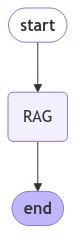

In [216]:
builder = StateGraph(MessagesState)

# define the nodes
builder.add_node("RAG", RAG)
# define the edges: these determine how the control flow moves
builder.add_edge(START, "RAG")
builder.add_edge("RAG", END)


memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))



In [217]:
user_query = "What is document about?"
config = {"configurable": {"thread_id": "abc123"}}


react_graph.invoke({"messages":HumanMessage(content=user_query)},config)



content='What is document about?' id='7a2e03ca-f21c-41e6-ad2b-bf8747a9021c'


{'messages': [HumanMessage(content='What is document about?', id='7a2e03ca-f21c-41e6-ad2b-bf8747a9021c'),
  AIMessage(content="The document is about various case studies and insights related to Aptus Data Labs' expertise in data science and AI solutions. It includes specific examples such as extracting valuable metadata using AI-powered text analytics for document management, a guide to generative AI, and achieving low-latency API-based queries with MongoDB. The document highlights the company's tailored solutions, services, and platforms, emphasizing their role in transforming data into actionable insights and improving business outcomes. It also provides information about the company's services, platforms, and contact details.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 5691, 'total_tokens': 5795, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 

In [156]:
react_graph.get_state(config).values["messages"]

[HumanMessage(content='What is document about?', id='caabcbf8-2daf-4454-8930-23f729e51e71'),
 AIMessage(content="The document is about various case studies and insights related to Aptus Data Labs' expertise in data science and AI solutions. It includes specific case studies such as extracting valuable metadata using AI-powered text analytics for document management, achieving low-latency API-based queries with MongoDB, and a guide to Generative AI. The document highlights Aptus Data Labs' services, platforms, and their approach to leveraging advanced technology to transform data into actionable insights, improve business outcomes, and enhance operational efficiency. It also provides information about the company's offerings, such as advisory services, data engineering, cloud solutions, AI and analytics, and more.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 5691, 'total_tokens': 5816, 'prompt_tokens_details': {'cac

In [207]:
### Reactr
def reasoner(state: MessagesState):
    
    chain = llm_with_tools
    output = chain.invoke([sys_msg]+state["messages"])
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)

    # prefix = "Final_Answer \n"+ output.content
    # output.content = prefix
    return {"messages": output}


def should_continue(state: MessagesState) -> Literal["tools","format_output","__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    try:
        if "FINAL ANSWER" in last_message.content:
            # Any agent decided the work is done
            return "format_output"
    except Exception as e:
        print(f"[ERROR]: Exception ====> {e} **should_continue**")
        return "__end__"

def format_output(state: MessagesState):
    last_message = state["messages"][-1]
    try:
        op = last_message.content.split("```")
        final_op =op[1].split("\n",1)[1]
        # print(final_op)
        # result = AIMessage(content=final_op)
        return {"messages": AIMessage(content=final_op)}
    except Exception as e:
        print(f"Excpetion occured ==== {e} **format_output**")
        return state

# Graph
builder = StateGraph(MessagesState)

# Add nodes
# builder.add_node("clusters", identify_clusters)
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools
builder.add_node("format_output", format_output)

# Add edges
builder.add_edge(START,"reasoner")
builder.add_conditional_edges(
    "reasoner",
    should_continue, # should_continue
    {"tools":"tools","format_output":"format_output","__end__":END}
)
builder.add_edge("tools", "reasoner")
builder.add_edge("format_output", END)
react_graph = builder.compile()


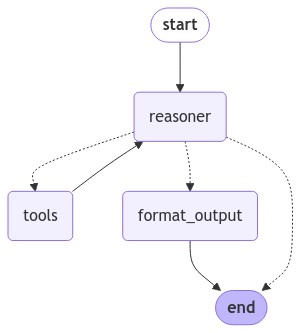

In [208]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))